# Relation between NO2 emission and Land Surface Temperature 

This is a follow-up notebook of the "NO2 emission and COVID Lockdown effects" notebook, where we explored the NO2 concentration during and post COVID lockdowns. During the finding, we noticed that there was a distinct pattern of rise and fall in the concentration with the change in temperature.

Hence, in this notebook, we want to explore the correlation between the concentration of NO2 caused by the change in temperature. Therefore, in this use case, we are using the NO2 layer of Sentinel-5P and the Land Surface Temperature(LST) layer of Sentinel-3 SLSTR.

References:
* https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-5P/Sentinel-5P_brings_air_pollution_into_focus
* https://ieeexplore.ieee.org/abstract/document/9617331

In [4]:
import openeo
from openeo.processes import merge_cubes
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

In [5]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


We want to maintain the same geographical extent as in the earlier notebook, focusing on the area around Delhi, India, for the year 2022. Specifically, we have chosen the post-COVID period to make assumptions based on data less influenced by factors such as reduced human activity.

In [6]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [77.11, 28.69],
            [77.11, 28.56],
            [77.29, 28.56],
            [77.29, 28.69],
            [77.11, 28.69],
        ]
    ],
}

## 1. Prepare a NO2 datacube

In [7]:
s5pollution = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-01-01", "2022-12-30"],
    spatial_extent=aoi,
    bands=["NO2"],
)

# Now aggregate by week to to perform weekly analysis
s5pollution = s5pollution.aggregate_temporal_period(reducer="mean", period="week")

## 2. Prepare temperature datacube

In [9]:
lst = connection.load_collection(
    "SENTINEL3_SLSTR_L2_LST",
    temporal_extent=["2022-01-01", "2022-12-30"],
    spatial_extent=aoi,
    bands=["LST_in:LST"],
)
lst = lst.rename_labels(dimension="bands", source=["LST_in:LST"], target=["LST"])

Typically, data is stored in a 16-bit format to prevent it from occupying large space by 32-bit floating points. Therefore, we apply offset and scaling in the following steps to bring Land Surface Temperature (LST) into the actual value range. The specific values for these adjustments are provided in the openEO collection documentation.

In [11]:
lst = 290 + (lst * 0.002)

# Now aggregate by week to perform weekly analysis
lst = lst.aggregate_temporal_period(reducer="mean", period="week")

Let's resample it to match resolution and pixel locations with Sentinel-5P datacube. 

In [12]:
lst_resampled = lst.resample_cube_spatial(target=s5pollution, method="bilinear")

## 3. Merge two datacubes

Then we use `merge_cube` process available in openEO to merge NO2 datacube and Temperature Datacube to create a composite cube in which we can perform further analysis.

In [13]:
merged_cube = s5pollution.merge_cubes(lst_resampled)

## 4. Download the merged cube

In [14]:
# Lets check if it is good or not
job = merged_cube.execute_batch(
    title="Air Pollution vs Tempreature Effect", outputfile="TempPollution.nc"
)

0:00:00 Job 'j-2401222405314c37a3a505ae7108465e': send 'start'
0:00:13 Job 'j-2401222405314c37a3a505ae7108465e': created (progress N/A)
0:00:18 Job 'j-2401222405314c37a3a505ae7108465e': created (progress N/A)
0:00:24 Job 'j-2401222405314c37a3a505ae7108465e': created (progress N/A)
0:00:32 Job 'j-2401222405314c37a3a505ae7108465e': created (progress N/A)
0:00:42 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:00:55 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:01:10 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:01:30 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:01:54 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:02:24 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:03:02 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:03:48 Job 'j-2401222405314c37a3a505ae7108465e': running (progress N/A)
0:04:47 Job 'j-2401222405314c37a3a505ae7108465e': running (pr

## 6. Let's do the plotting and further analysis

In [27]:
dataset = xr.load_dataset("TempPollution.nc")

In [28]:
# rolling for an smooth effect
dataset = dataset.rolling(t=3).mean()

Text(0.5, 1.0, 'NO2 vs Temperature')

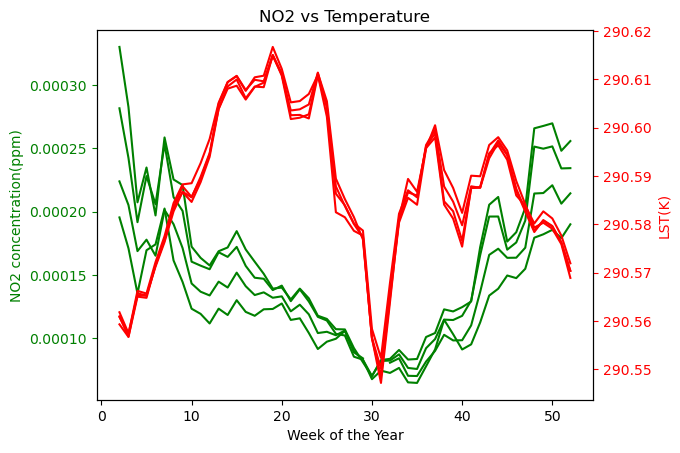

In [29]:
fig, ax1 = plt.subplots(dpi=100)
ax1.plot(np.nanmean(dataset.NO2.to_numpy(), axis=1), color="g", label="NO2")
ax1.set_ylabel("NO2 concentration(ppm)")
ax1.yaxis.label.set_color("g")
ax1.tick_params(axis="y", colors="g")

ax2 = ax1.twinx()
ax2.plot(np.nanmean(dataset["LST"].to_numpy(), axis=1), color="r", label="LST")
ax2.set_ylabel("LST(K)")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis="y", colors="r")

ax1.set_xlabel("Week of the Year")
plt.title("NO2 vs Temperature")

##### The plot above suggests a potential relationship between the two parameters, with one increasing as the other decreases up to the 30th week. Afterward, both parameters increase together. Let's investigate further to determine if there is a correlation between them.

Text(0, 0.5, 'Temp')

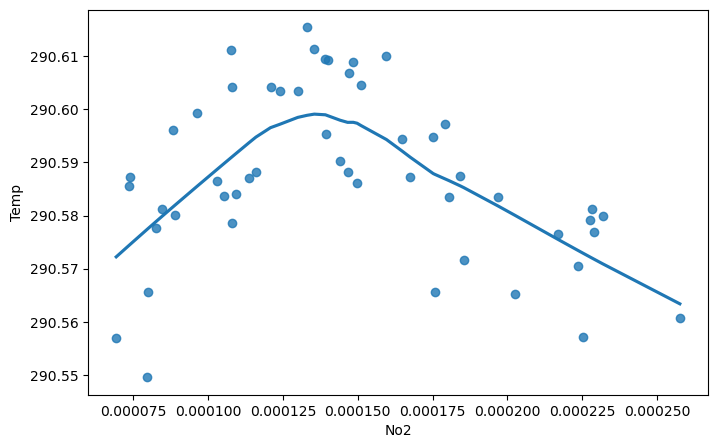

In [30]:
fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)
sns.regplot(
    x=np.nanmean(np.nanmean(dataset.NO2.to_numpy(), axis=1), axis=1).flatten(),
    y=np.nanmean(np.nanmean(dataset["LST"].to_numpy(), axis=1), axis=1).flatten(),
    lowess=True,
)
ax1.set_xlabel("No2")
ax1.set_ylabel("Temp")

##### The curve further suggests a potential relationship, but it remains inconclusive. It seems like there might be a seasonal pattern, with one parameter shows an increasing trend while the other decreases. Therefore, dividing the data into seasons and applying different fits could be useful to gain a better understanding and characterize the correlation between the two parameters.

In [31]:
dataset["t"] = dataset.t.dt.season

In [33]:
df_copy = xr.Dataset(coords={"t": dataset["t"]})
df_copy

<xarray.Dataset>
Dimensions:  (t: 53)
Coordinates:
  * t        (t) object 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'
Data variables:
    *empty*

In [35]:
df_copy["NO2"] = dataset.NO2.mean(dim="x", skipna=True).mean(dim="y", skipna=True)
df_copy["LST"] = dataset["LST"].mean(dim="x", skipna=True).mean(dim="y", skipna=True)

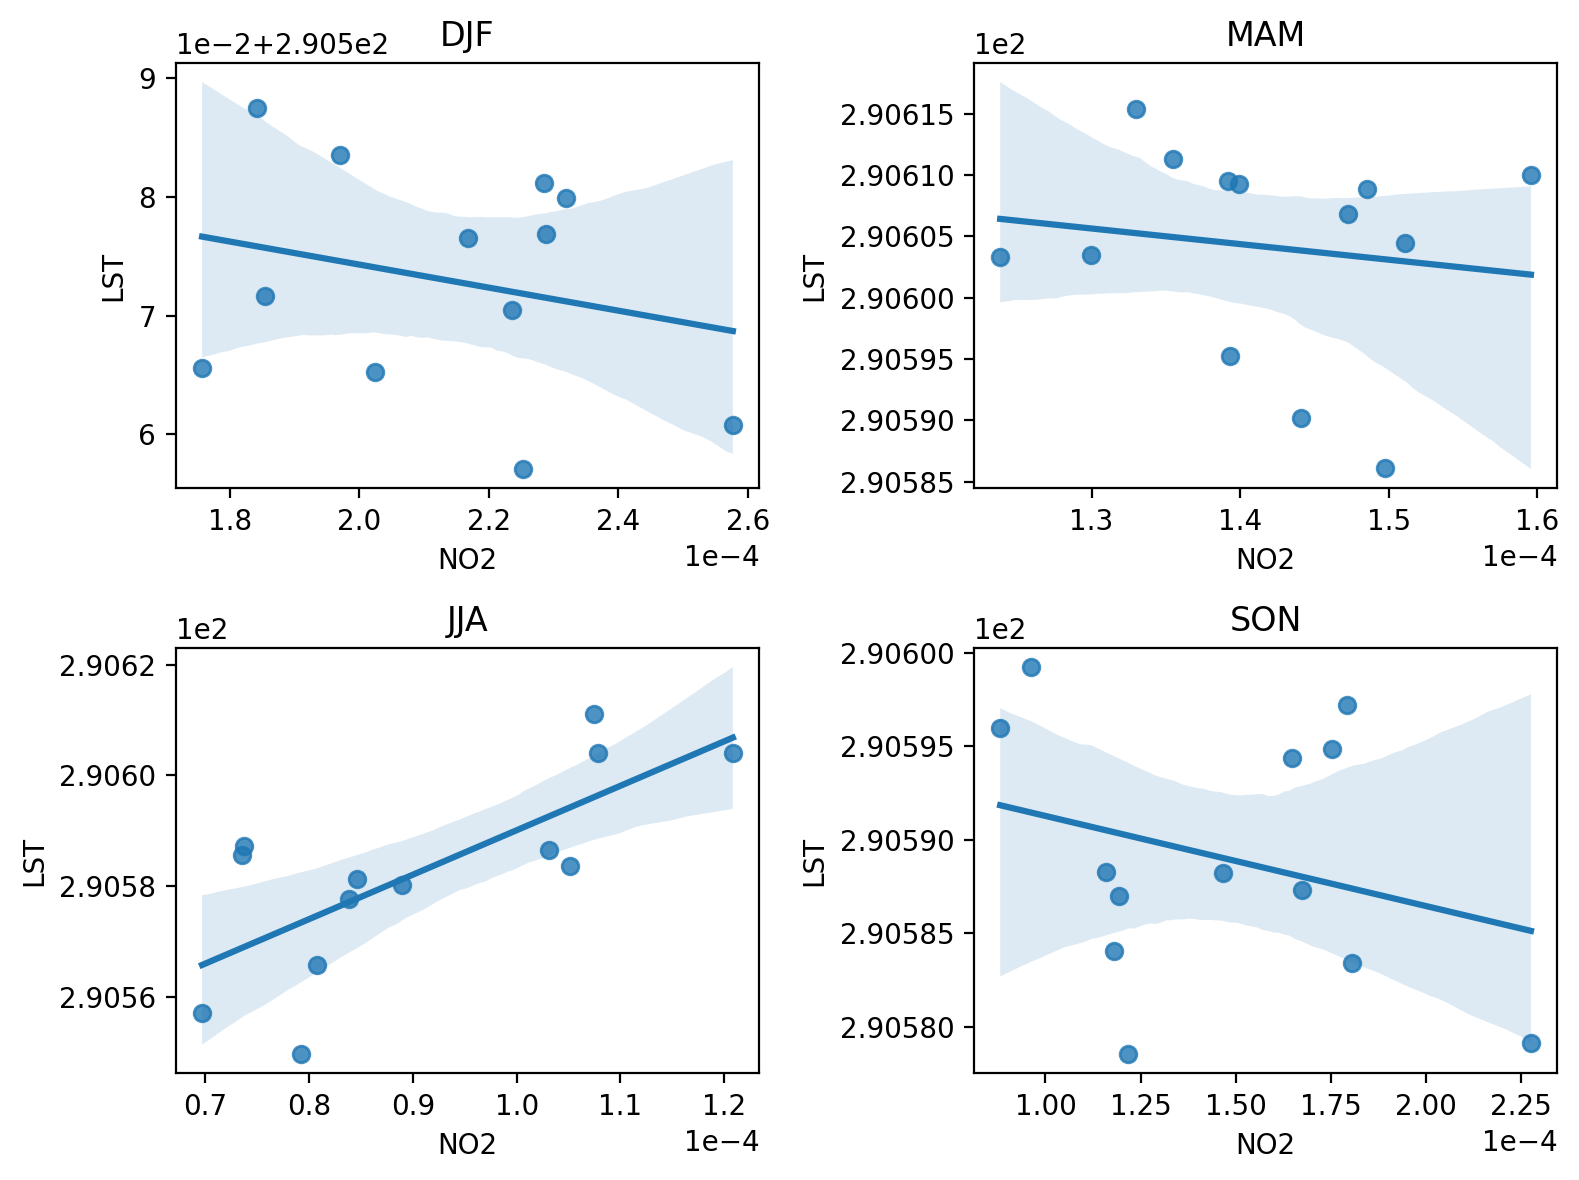

In [39]:
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(8, 6))
for i in range(4):
    season = seasons[i]
    a = math.floor(i / 2)
    b = i % 2
    sns.regplot(
        x=df_copy.sel(t=season).NO2,
        y=df_copy.sel(t=season).LST,
        lowess=False,
        ax=axs[a][b],
    )
    axs[a][b].set_title(season)
    axs[a][b].ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
    axs[a][b].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

From the analysis, it's evident that the relationship is notably strong during the "JJA" (June, July, August) seasons with an increasing trend. However, in the seasons "SON" (September, October, November), "DJF" (December, January, February), and "MAM" (March, April, May), which represent the other months, the correlation is not very strong.

In conclusion, for this geographical region, it can be confidently stated that NO2 exhibits a direct correlation during the summer months, while there is nexplicitlyly defining relationship in the other seasons. Consequently, the parameters may not be significantly dependent on each other during those periods.